## 逻辑回归

### 获取数据

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

FILENAME = r'D:\Code\GitHub\notebook\machine_learning\datasets\smsspamcollection\SMSSpamCollection'

# 读取数据（http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection）
df = pd.read_csv(FILENAME, delimiter='\t', header=None)
print(df.head())
print(df[df[0]=='ham'][0].count())
print(df[df[0]=='spam'][0].count())

      0                                                  1
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
4825
747


### 逻辑回归

In [2]:
# LogisticRegression 就是一个被logistic方程归一化后的线性回归，主要用于Classification

'''
TF-IDF(Term Frequency-Inverse Document Frequency, 词频-逆文件频率)
TF（Term Frequency）词频，某个词在文章中出现的次数或频率，如果某篇文章中的某个词出现多次，那这个词可能是比较重要的词
IDF（inverse document frequency）逆文档频率，这是一个词语“权重”的度量，在词频的基础上，如果一个词在多篇文档中词频较低，
也就表示这是一个比较少见的词，但在某一篇文章中却出现了很多次，则这个词IDF值越大，在这篇文章中的"权重"越大。所以当一个词越常见，IDF越低。
当计算出TF和IDF的值后，两个一乘就得到TF-IDF，这个词的TF-IDF越高就表示，就表示在这篇文章中的重要性越大，越有可能就是文章的关键词

Sklearn中CountVectorizer类会将文本中的词语转换为词频矩阵。矩阵中word[i][j]，它表示j词在i类文本下的词频
TfidfTransformer类用于统计每个词语的TF-IDF值
参考：https://zhuanlan.zhihu.com/p/27330205?utm_source=tuicool&utm_medium=referral
'''

'''
fit_transform(traindata)对部分数据先拟合fit，找到该part的整体指标，如均值、方差、最大值最小值等等（根据具体转换的目的），
然后对该traindata进行转换transform，从而实现数据的标准化、归一化等等。。
根据对之前部分fit的整体指标，对剩余的数据（testdata）使用同样的均值、方差、最大最小值等指标进行转换transform(testdata)，
从而保证traindata、testdata处理方式相同。
必须先用fit_transform(traindata)，之后再transform(testdata)，如果直接transform(traindata)，程序会报错
如果fit_transfrom(traindata)后，使用fit_transform(testdata)而不用transform(testdata)，虽然也能归一化，但是两个结果不是在同一个“标准”下的，
具有明显差异。
参考：http://m.blog.csdn.net/anecdotegyb/article/details/74857055
'''

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score

X_train_raw, X_test_raw, y_train, y_test = train_test_split(df[1], df[0], random_state=42)

vectorizer = TfidfVectorizer()
# 第一个fit_transform是计算tf-idf，第二个fit_transform是将文本转为词频矩阵
X_train = vectorizer.fit_transform(X_train_raw)
X_test = vectorizer.transform(X_test_raw)

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)

# 这里i取值是0..4，而X_test_raw的索引不是0..4，要先通过X_test_raw.index[i]取得X_test_raw的索引值
for i, prediction in enumerate(predictions[:5]):
    print('Prediction: %s. Message: %s' %(prediction, X_test_raw[X_test_raw.index[i]]))

Prediction: ham. Message: Squeeeeeze!! This is christmas hug.. If u lik my frndshp den hug me back.. If u get 3 u r cute:) 6 u r luvd:* 9 u r so lucky;) None? People hate u:
Prediction: ham. Message: And also I've sorta blown him off a couple times recently so id rather not text him out of the blue looking for weed
Prediction: ham. Message: Mmm thats better now i got a roast down me! id b better if i had a few drinks down me 2! Good indian?
Prediction: ham. Message: Mm have some kanji dont eat anything heavy ok
Prediction: ham. Message: So there's a ring that comes with the guys costumes. It's there so they can gift their future yowifes. Hint hint


### 评价模型（precision、recall、f1）

In [3]:
# cross_val_score：这个函数的返回值就是对于每次不同的的划分train_data时，在test_data上得到的分类的准确率
# 准确率的算法可以通过score_func参数指定，如果不指定的话，是用模型默认自带的准确率算法
# Precision = TP/(TP+FP)
# Recall = TP/(TP+FN)
# F1 = 2/(1/precision+1/recall) = TP/(TP+(FN+FP)/2)
accuracy = cross_val_score(classifier, X_train, y_train, cv=5)
print('accuracy:', accuracy)

# 对于precision/recall/f1计算，需要对数据进行二进制化，否则会出错。详细可以参考：
# https://codedump.io/share/Rufb5kFeh9m0/1/scikit-learn-script-giving-vastly-different-results-than-the-tutorial-and-gives-an-error-when-i-change-the-dataframes
# https://stackoverflow.com/questions/27357121/scikit-calculate-precision-and-recall-using-cross-val-score-function
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, make_scorer
# Precision
precision_scorer = make_scorer(precision_score, pos_label='spam')
precisions = cross_val_score(classifier, X_train, y_train, cv=5, scoring=precision_scorer)
print('precison:', precisions)
# Recall
recall_scorer = make_scorer(recall_score, pos_label='spam')
recalls = cross_val_score(classifier, X_train, y_train, cv=5, scoring=recall_scorer)
print ('recall:', recalls)
# F1
f1_scorer = make_scorer(f1_score, pos_label='spam')
f1 = cross_val_score(classifier, X_train, y_train, cv=5, scoring=f1_scorer)
print ('f1:', f1)

accuracy: [ 0.95340502  0.96291866  0.9437799   0.95568862  0.94491018]
precison: [ 0.97435897  1.          1.          1.          0.97142857]
recall: [ 0.67256637  0.72321429  0.58035714  0.66964286  0.60714286]
f1: [ 0.79581152  0.83937824  0.73446328  0.80213904  0.74725275]


### ROC

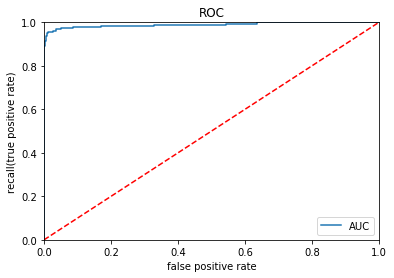

In [4]:
# 评价模型的另外一种方法：ROC曲线（只适用于Binary classification）
# True Positive Rate(Recall) VS False Positive Rate
from sklearn.metrics import roc_curve, auc

# predict_proba返回的是一个n行k列的数组，第i行第j列上的数值是模型预测第i个预测样本的标签为j的概率。所以每一行的和应该等于1
predictions = classifier.predict_proba(X_test)
false_positive_rate, recall, thresholds = roc_curve(y_test, predictions[:, 1], pos_label='spam')
roc_auc = auc(false_positive_rate, recall)

plt.title('ROC')
plt.plot(false_positive_rate, recall, label='AUC')
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('recall(true positive rate)')
plt.xlabel('false positive rate')
plt.show()

### Grid Search（网格搜索）

In [5]:
# 机器学习的数据输入往往需要很多数据转换步骤，Sklearn提供了pipeline类来帮助完成这些转换
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('vect', TfidfVectorizer(stop_words='english')),
    ('clf', LogisticRegression())
])

parameters = {
    'vect__max_df': (0.25, 0.5, 0.75),
    'vect__stop_words': ('english', None),
    'vect__max_features': (2500, 5000, 10000, None),
    'vect__ngram_range': ((1,1), (1,2)),
    'vect__use_idf': ('True', 'False'),
    'vect__norm': ('l1', 'l2'),
    'clf__penalty': ('l1', 'l2'),
    'clf__C': (0.01, 0.1, 1, 10),
}

X_train, X_test, y_train, y_test = train_test_split(df[1], df[0], random_state=42)

# Grid Search找出提供的参数组合中对应scoring方法的最佳参数
grid_search = GridSearchCV(pipeline, parameters, n_jobs=4, verbose=1, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

print('Best score: %.2f' %grid_search.best_score_)
print('Best parameters set:')
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print('\t%s: %r' % (param_name, best_parameters[param_name]))
predictions = grid_search.predict(X_test)
print('Accuracy:', accuracy_score(y_test, predictions))
# 注意这里和上面一样，对于precision/recall/f1计算，需要加上pos_label
print('Precision:', precision_score(y_test, predictions, pos_label='spam'))
print('Recall:', recall_score(y_test, predictions, pos_label='spam'))

Fitting 5 folds for each of 1536 candidates, totalling 7680 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   16.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   47.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  3.0min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  4.6min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  6.7min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed:  9.3min
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed: 12.2min
[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed: 15.5min
[Parallel(n_jobs=4)]: Done 4992 tasks      | elapsed: 19.3min
[Parallel(n_jobs=4)]: Done 6042 tasks      | elapsed: 25.6min
[Parallel(n_jobs=4)]: Done 7192 tasks      | elapsed: 37.1min
[Parallel(n_jobs=4)]: Done 7680 out of 7680 | elapsed: 39.1min finished


Best score: 0.98
Best parameters set:
	clf__C: 10
	clf__penalty: 'l2'
	vect__max_df: 0.25
	vect__max_features: 10000
	vect__ngram_range: (1, 2)
	vect__norm: 'l2'
	vect__stop_words: None
	vect__use_idf: 'True'
Accuracy: 0.989231873654
Precision: 0.988571428571
Recall: 0.930107526882


### 多类别分类

In [6]:
FILENAME = r'D:\Code\GitHub\notebook\machine_learning\datasets\movies\train.tsv'
# 读取数据
df = pd.read_csv(FILENAME, header=0, delimiter='\t')
df.info()
print(df.head())
df['Sentiment'].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
PhraseId      156060 non-null int64
SentenceId    156060 non-null int64
Phrase        156060 non-null object
Sentiment     156060 non-null int64
dtypes: int64(3), object(1)
memory usage: 4.8+ MB
   PhraseId  SentenceId                                             Phrase  \
0         1           1  A series of escapades demonstrating the adage ...   
1         2           1  A series of escapades demonstrating the adage ...   
2         3           1                                           A series   
3         4           1                                                  A   
4         5           1                                             series   

   Sentiment  
0          1  
1          2  
2          2  
3          2  
4          2  


count    156060.000000
mean          2.063578
std           0.893832
min           0.000000
25%           2.000000
50%           2.000000
75%           3.000000
max           4.000000
Name: Sentiment, dtype: float64

In [7]:
# Gridsearch参数
pipeline = Pipeline([
    ('vect', TfidfVectorizer(stop_words='english')),
    ('clf', LogisticRegression()),
])

parameters = {
    'vect__max_df': (0.25, 0.5),
    'vect__ngram_range': ((1,1), (1,2)),
    'vect__use_idf': (True, False),
    'clf__C': (0.1, 1, 10),
}
X, y = df['Phrase'], df['Sentiment'].as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)
# Grid Search找出提供的参数组合中对应scoring方法的最佳参数
grid_search = GridSearchCV(pipeline, parameters, n_jobs=4, verbose=1, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)
print('Best Score: %.3f' %grid_search.best_score_)
print('Best Parameters set:')
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print('\t%s: %r' %(param_name, best_parameters[param_name]))

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:  8.9min finished


Best Score: 0.629
Best Parameters set:
	clf__C: 10
	vect__max_df: 0.25
	vect__ngram_range: (1, 2)
	vect__use_idf: False


In [8]:
# 混淆矩阵的每一列代表了预测类别，每一列的总数表示预测为该类别的数据的数目，每一行代表了数据的真实归属类别，每一行的数据总数表示该类别的数据实例的数目
# https://en.wikipedia.org/wiki/Confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix

predictions = grid_search.predict(X_test)
print('Accuracy:', accuracy_score(y_test, predictions))
print('Confusion Matrix:', confusion_matrix(y_test, predictions))
print('Classification Report:', classification_report(y_test, predictions))

Accuracy: 0.635845187748
Confusion Matrix: [[ 1187  1540   659    89    10]
 [  997  5955  6175   569    36]
 [  230  3060 32695  3593   176]
 [   22   417  6509  8158  1342]
 [    2    33   524  2432  1620]]
Classification Report:              precision    recall  f1-score   support

          0       0.49      0.34      0.40      3485
          1       0.54      0.43      0.48     13732
          2       0.70      0.82      0.76     39754
          3       0.55      0.50      0.52     16448
          4       0.51      0.35      0.42      4611

avg / total       0.62      0.64      0.62     78030

